In [1]:
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns
import datetime
from sqlalchemy import create_engine
from lib.utils import sql_from_cache, year, sem
%matplotlib inline
%load_ext autoreload
%autoreload 2

Só pessoas autorizadas tem acesso ao base do Moodle (na verdade, é uma cópia quase síncrone da base e só leitura). A senha fica num arquivo dbpass.txt que não vai ficar no repositório.

Criamos dois engines abaixo: um com acesso à database `moodle_usp` e outro a database `usp` (nossa cópia das informações sobre matriculas e pessoas do Júpiter). 

O objetivo agora é criar arquivos texto com informações em formato intermediário, que podem ser analisados sem acesso direto às bases da USP.

In [3]:
dbpass = open('dbpass.txt').read().strip()
engine = create_engine('mysql+mysqlconnector://edustats:{}@200.144.245.242:60331/moodle_usp'.format(dbpass), encoding='utf8')
engine_usp = create_engine('mysql+mysqlconnector://edustats:{}@200.144.245.242:60331/usp'.format(dbpass), encoding='utf8')
pd.read_sql_query("select timecreated from mdl_logstore_standard_log order by timecreated desc limit 1",engine,parse_dates=['timecreated'])

,timecreated
0,2021-05-26 12:43:44


## Ministrantes
Para padronizar o número de ambientes criados pelo número de ministrantes, precisamos uma tabela com estes dados. Vou pegar da cópia do sybase (a tabela `usp`) do ano corrente. 

In [ ]:
turmas_gr = pd.read_sql_query("select timecreateddesc from mdl_logstore_standard_log order by timecreated  limit 1",engine_usp)

In [3]:
unidades = pd.read_sql_table('unidade',con=engine_usp)
unidades

,id,codund,tipund,codcam,sglund,nomund
0,1,1,Órgãos Centrais - Direção e Serviço,10,RUSP,Reitoria da Universidade de São Paulo
1,2,2,Ensino e Pesquisa,10,FD,Faculdade de Direito
2,3,3,Ensino e Pesquisa,10,EP,Escola Politécnica
3,4,4,Centros e Institutos Especializados,10,IEE,Instituto de Energia e Ambiente
4,5,5,Ensino e Pesquisa,10,FM,Faculdade de Medicina
...,...,...,...,...,...,...
96,97,202,Entidades Associadas,10,IMESC,Instituto de Medicina Social e de Criminologia...
97,98,203,Entidades Associadas,60,HCFMRP,Hospital das Clínicas da Faculdade de Medicina...
98,99,204,Entidades Associadas,10,HCFMUSP,Hospital das Clínicas da Faculdade de Medicina...
99,100,205,Entidades Associadas,10,FAP,Fundação Antonio Prudente


O arquivo `servidor-disc-turma` foi criado com o SQL `select p.codpes,p.coddis,p.codtur,v.codund from CEPAVIEW_MINISTRANTE p join CEPAVIEW_VINCULOPESSOAUSP v on p.codpes = v.codpes where v.tipvin = 'SERVIDOR'`.  A ideia é contar o número de ministrantes e número de turmas por unidade.

In [4]:
doctur = pd.read_table('data/nonpublic/servidor-disc-turma.csv')
print(len(doctur))
doctur = doctur.dropna()
doctur['codund'] = doctur['codund'].astype('int16')
print(len(doctur))
doctur = pd.merge(doctur,unidades[['codund','sglund']],on='codund',how='left')
doctur['ano'] = doctur['codtur'].apply(lambda s: int(s[:4]))
doctur = doctur[doctur['ano'] < 2021]
doctur.info()

942594
942593
<class 'pandas.core.frame.DataFrame'>
Int64Index: 927146 entries, 0 to 942592
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   codpes  927146 non-null  int64 
 1   coddis  927146 non-null  object
 2   codtur  927146 non-null  object
 3   codund  927146 non-null  int16 
 4   sglund  927146 non-null  object
 5   ano     927146 non-null  int64 
dtypes: int16(1), int64(2), object(3)
memory usage: 44.2+ MB


In [6]:
doctur.query('codpes == 155469')

,codpes,coddis,codtur,codund,sglund,ano
409218,155469,4300152,2012104,43,IF,2012
409219,155469,4300152,2012104,43,IF,2012
409220,155469,4300152,2013102,43,IF,2013
409221,155469,4300152,2013102,43,IF,2013
409222,155469,4300152,2013111,43,IF,2013
...,...,...,...,...,...,...
409325,155469,FGE1189,2004102,43,IF,2004
409326,155469,FGE2255,2005210,43,IF,2005
409327,155469,FGE2255,2005220,43,IF,2005
409328,155469,FGE2255,2006210,43,IF,2006


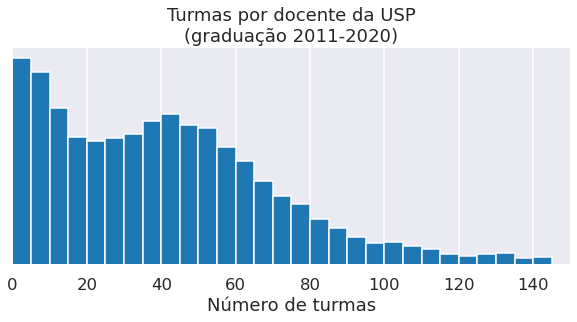

In [157]:
sns.set_context('talk')
sns.set_style('dark')
fig = plt.figure(figsize=(10,4))
counts = doctur.query("ano > 2010 & ano < 2021")['codpes'].value_counts()
ax = counts.hist(bins=range(0,150,5))
ax.set_xlim(0,150)
ax.set_yticks([])
ax.set_xlabel("Número de turmas")
ax.set_title("Turmas por docente da USP\n(graduação 2011-2020)")
sns.despine()

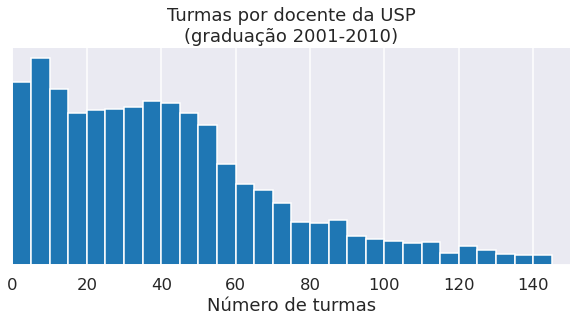

In [156]:
sns.set_context('talk')
sns.set_style('dark')
fig = plt.figure(figsize=(10,4))
counts = doctur.query("ano > 2000 & ano < 2011")['codpes'].value_counts()
ax = counts.hist(bins=range(0,150,5))
ax.set_xlim(0,150)
ax.set_yticks([])
ax.set_xlabel("Número de turmas")
ax.set_title("Turmas por docente da USP\n(graduação 2001-2010)")
sns.despine()

In [159]:
counts.describe()

count    7568.000000
mean       55.426533
std        77.080340
min         1.000000
25%        17.000000
50%        40.000000
75%        64.000000
max      1508.000000
Name: codpes, dtype: float64

In [80]:
docdistur = doctur.groupby(['sglund','ano']).agg({'codpes':'nunique','coddis':'nunique','codtur':'count'})
docdistur.columns = ['docentes','disciplinas','turmas']

In [82]:
docdistur.loc['EACH']

,docentes,disciplinas,turmas
ano,,,
1998,11,33,72
1999,12,26,65
2000,10,25,63
2001,11,28,66
2002,12,30,87
2003,16,45,106
2004,14,46,99
2005,72,97,293
2006,119,196,697


In [84]:
docdistur.to_csv('data/processed/docdistur.csv',index=True)

In [102]:
docdistur.reset_index().groupby('ano')['docentes'].sum()

ano
1993       1
1994       1
1997      42
1998    4078
1999    4219
2000    4268
2001    4409
2002    4509
2003    4645
2004    4825
2005    5016
2006    5195
2007    5310
2008    5366
2009    5537
2010    5576
2011    5472
2012    5425
2013    5436
2014    5502
2015    5518
2016    5467
2017    5372
2018    5310
2019    5172
2020    5132
Name: docentes, dtype: int64

In [117]:
import datetime
now = datetime.datetime.now()
now

datetime.datetime(2021, 3, 29, 19, 15, 33, 769550)

In [115]:
pessoa = pd.read_sql_table('pessoa',columns=['codpes','sexpes','dtanas'],con=engine_usp)
pessoa['idade'] = (now - pessoa['dtanas']).apply(lambda td: td.days/364.25)
pessoa = pessoa.set_index('codpes')

pessoa.sample(5)

,sexpes,dtanas,idade
codpes,,,
12051897,M,1999-05-13,21.938229
2669452,M,1942-11-21,78.566918
1817948,F,1956-06-23,64.941661
3049897,M,1961-11-10,59.544269
10259665,F,1988-10-18,32.532601


In [116]:
pessoa.dtypes

sexpes            object
dtanas    datetime64[ns]
idade            float64
dtype: object

In [14]:
doctur20 = doctur.query("ano == 2020")

In [53]:
docs = doctur20.groupby(['codpes']).agg({'codtur':'count','coddis':'nunique','codtur':'count','sglund':'first'})
docs.columns = ['nturmas','ndisc','unidade']
docs

,nturmas,ndisc,unidade
codpes,,,
16202,1,1,FAU
17162,3,1,RUSP
17631,3,1,FMRP
18305,2,1,IFSC
20062,1,1,FFLCH
...,...,...,...
11736717,10,2,IME
11742749,3,2,FEA
11944139,18,6,FMRP


In [17]:
li20 = pd.read_csv('data/nonpublic/loggedin20.csv')

In [20]:
li20[:3]

,timecreated,userid
0,2020-01-01 03:12:14,196673
1,2020-01-01 03:13:10,60688
2,2020-01-01 03:18:58,196673


In [64]:
nli = li20.groupby('userid').count()
nli.columns = ['nlogins']



In [65]:
nli

,nlogins
userid,
2,708
6,439
7,301
9,29
10,181
...,...
312357,1
312358,1
312359,1


In [81]:
users = pd.read_csv('data/nonpublic/users.csv')
users.columns = ['userid','codpes']
users = users.set_index('userid')
users

,codpes
userid,
125917,7696100
70819,1301971
45613,8024860
49252,8629385
78667,8642644
...,...
51051,999335
299512,999464
307044,999609


In [86]:
nli2 = users.join(nli,how='inner')
nli2 = nli2.reset_index()
nli2 = nli2.set_index('codpes')

In [87]:
nli2

,userid,nlogins
codpes,,
361744,43237,4
4574450,61238,135
8960142,44482,4
8990010,47205,1
9317211,71997,16
...,...,...
999165,184149,64
9992077,301603,26
999464,299512,59


In [120]:
doc2 = docs.join(nli2)
doc2 = doc2.fillna(0)
doc2['nlogins'] = doc2['nlogins'].astype(int)
docentes = doc2.join(pessoa)
docentes.sort_values(by='nlogins',ascending=False)

,nturmas,ndisc,unidade,userid,nlogins,sexpes,dtanas,idade
codpes,,,,,,,,
699362,16,6,IFSC,458.0,1899,M,1970-03-05,51.206589
71362,5,2,IME,131258.0,1020,M,1952-11-16,68.551819
91267,7,3,IME,283534.0,923,M,1963-07-08,57.883322
1748232,5,3,EP,21.0,789,F,1962-11-27,58.495539
53671,4,3,IFSC,299338.0,735,M,1963-05-26,58.001373
...,...,...,...,...,...,...,...,...
1788683,5,2,FM,0.0,0,F,1951-10-14,69.647220
1785888,11,3,FM,0.0,0,M,1959-07-07,61.897049
1767623,6,3,FAU,0.0,0,F,1956-11-04,64.573782


Index(['EP', 'FFLCH', 'EACH', 'FM', 'FMRP', 'ESALQ', 'FFCLRP', 'EESC', 'IME',
       'ECA', 'FEA', 'FD', 'EEL', 'FO', 'FAU', 'ICMC', 'FZEA', 'IB', 'IQ',
       'IF', 'FE', 'FMVZ', 'ICB', 'FEARP', 'FSP'],
      dtype='object', name='unidade')

In [136]:
sns.set_context('talk',font_scale=1.3)

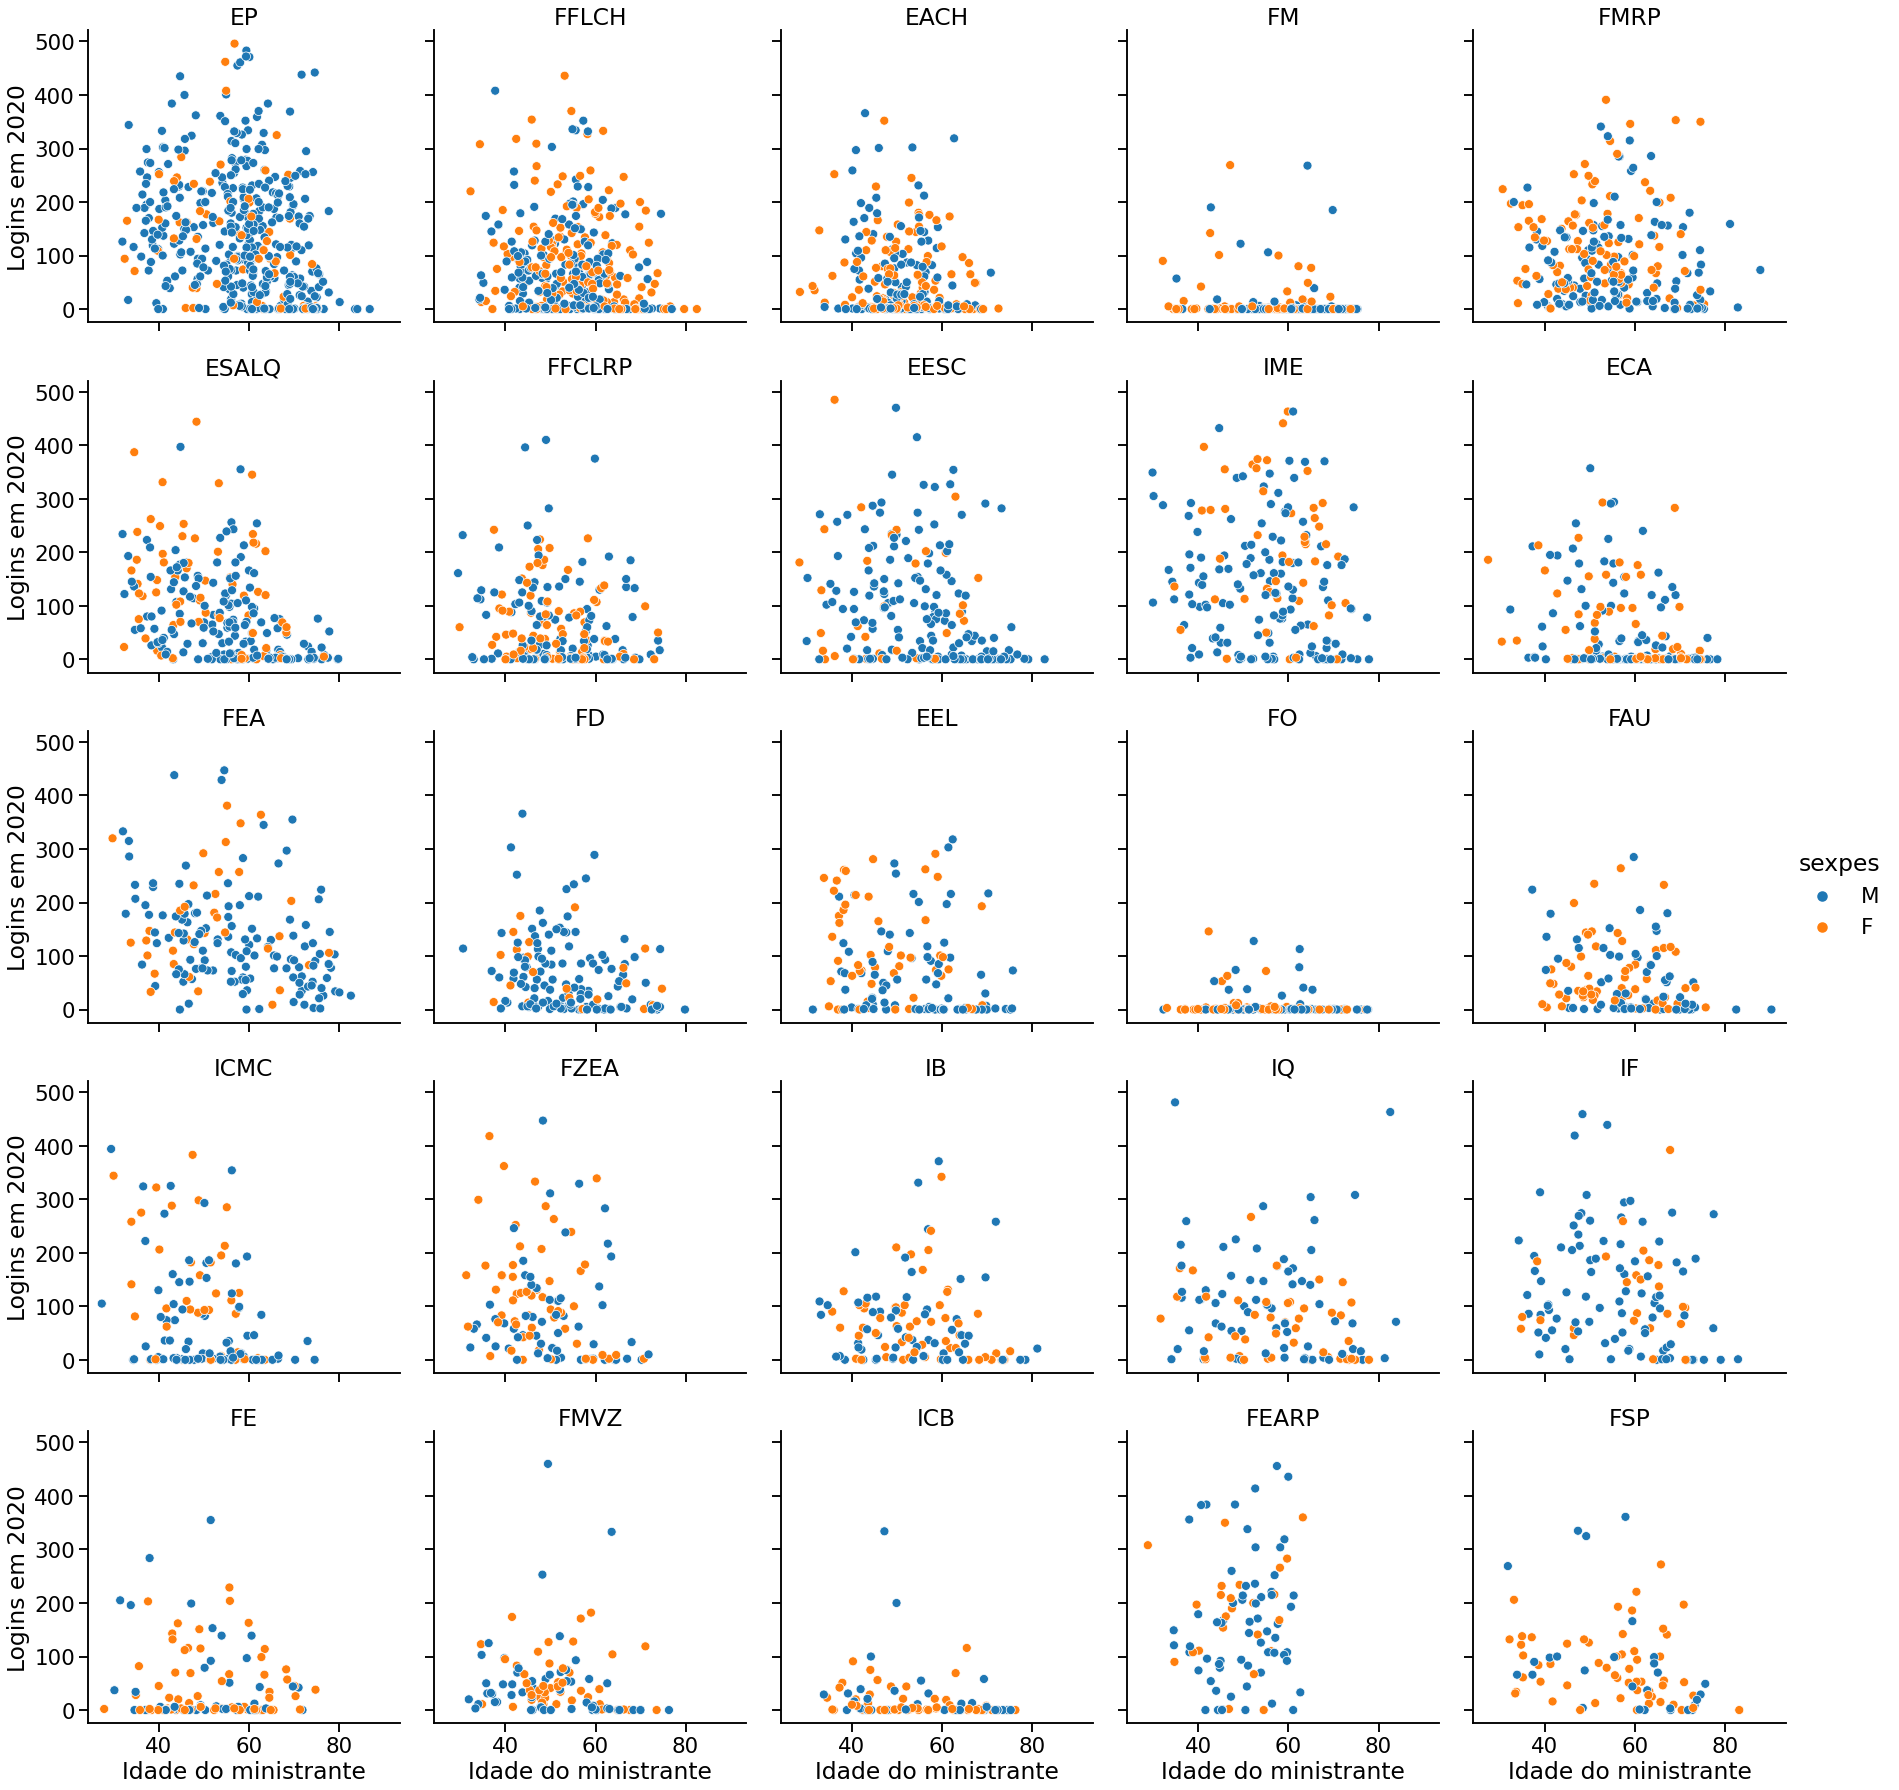

In [160]:
unitoplot = docentes.groupby('unidade')['nturmas'].count().sort_values(ascending=False)[:25].index
#unitoplot = ["IEE"]
g = sns.relplot(data=docentes.query("nlogins < 500 & unidade in @unitoplot"),x='idade',y='nlogins',
                hue='sexpes',col='unidade',col_wrap=5,col_order=unitoplot)
g.set_axis_labels("Idade do ministrante", "Logins em 2020")
g.set_titles("{col_name}")
fig = plt.gcf()
fig.savefig('figs/docentes.png')

52.7522306108442

In [113]:
pessoa

KeyError: "None of ['codpes'] are in the columns"

In [110]:
docentes.join()

,nturmas,ndisc,unidade,userid,nlogins
codpes,,,,,
16202,1,1,FAU,0.0,0
17162,3,1,RUSP,0.0,0
17631,3,1,FMRP,67054.0,73
18305,2,1,IFSC,0.0,0
20062,1,1,FFLCH,0.0,0
...,...,...,...,...,...
11736717,10,2,IME,298524.0,305
11742749,3,2,FEA,304506.0,195
11944139,18,6,FMRP,302746.0,62


### Turmas e disciplinas da USP
Para comparar (a quantidade de) ambientes e docentes no Moodle da USP precisamos saber os números da USP. A seguir, vamos criar uma tabela com todas as disciplinas, # de turmas, número de matriculados e ministrantes. Executei queries do tipo
```
select coddis, codtur, count(*) matr from CEPAVIEW_HISTESCOLARGR 
where codtur like '2017%' and stamtr in ('I','P','M') 
group by coddis,codtur
```
e salvei em formato csv.

(Abandonei a tentativa de usar a cópia das informações no Júpiter e Janus que o Moodle usa, porque esta cópia somente pega matriculas do ano corrente)

In [4]:
#turmas181 = pd.read_table('/home/ewout/notebooks/MoodleAnalytics/matrgr2018-1.csv')

turmas20 = pd.read_csv('data/raw/matrgr2020.csv',sep='\t');turmas20['ano'] = 2020

In [5]:
turmas20.head(4)

,coddis,codtur,matr,ano
0,0060006,2020101,40,2020
1,0060007,2020201,35,2020
2,0060008,2020101,22,2020
3,0060009,2020201,26,2020


In [6]:
turmas19 = pd.read_csv('data/raw/matrgr2019.csv',sep='\t');turmas19['ano'] = 2019
turmas18 = pd.read_csv('data/raw/matrgr2018.csv',sep='\t');turmas18['ano'] = 2018
turmas17 = pd.read_csv('data/raw/matrgr2017.csv',sep='\t');turmas17['ano'] = 2017
turmas16 = pd.read_csv('data/raw/matrgr2016.csv',sep='\t');turmas16['ano'] = 2016
turmas15 = pd.read_csv('data/raw/matrgr2015.csv',sep='\t');turmas15['ano'] = 2015
turmas14 = pd.read_csv('data/raw/matrgr2014.csv',sep='\t');turmas14['ano'] = 2014
turmas13 = pd.read_csv('data/raw/matrgr2013.csv',sep='\t');turmas13['ano'] = 2013
turmas12 = pd.read_csv('data/raw/matrgr2012.csv',sep='\t');turmas12['ano'] = 2012

In [7]:
turmas = pd.concat([turmas12,turmas13,turmas14,turmas15,turmas16,turmas17,turmas18,turmas19,turmas20])

Gerei o arquivo matrgr2020.csv em 3 de novembro de 2020, Espero que com exceção dos cursos quadrimestral os números não devem mudar muito mais.

In [8]:
turmas.sample(5)

,coddis,codtur,matr,ano
5386,BMM0126,2019111,53,2019
981,2200200,2018201,73,2018
17075,QFL2452,2015110,14,2015
8890,FLC0186,2014201,35,2014
18994,SEP0566,2014201,50,2014


Peguei uma tabela do anuário estatístico (T3-02) para relacionar prefixo (primeiras três letras) do código da disciplina da graduação com a unidade. Esta tabela do anuário é só para graduação, porém. 

In [9]:
t2 = pd.read_csv('data/raw/anuario-T3-02-turmas.csv',sep='\t',decimal=',')
t2.columns = ['unidadetipo','unidade','pfx','dept','metrica','semestre','total']
pfxs = t2[['unidade','pfx']]
pfxs = pfxs.drop_duplicates()
pfxs[pfxs['unidade'] == 'IF']

,unidade,pfx
2190,IF,430
2200,IF,431
2210,IF,432


In [10]:
def tursem(codtur):
    try:
        return codtur[4]
    except:
        return
    
def aggsem(semestre):
    if len(semestre) == 1:
        return semestre[0]
    else:
        return "ambos"

def pfx(disc):
    return disc[:3]

turmas['semestre'] = turmas['codtur'].apply(tursem)
turmas['pfx'] = turmas['coddis'].apply(pfx)

dis = turmas.groupby(['coddis','ano'],as_index=False).agg({'codtur':'count','pfx':'first','matr':np.sum,'semestre':'unique'})
dis['semestre'] = dis['semestre'].apply(aggsem)
dis = dis.rename({'codtur':'turmas'},axis=1)
disc = pd.merge(dis,pfxs,on='pfx',how='left')


In [11]:
# turmas de graduação 2012-2019
turmas.sample(10)

,coddis,codtur,matr,ano,semestre,pfx
15475,PLC0032,2015202,17,2015,2,PLC
19611,SQF0328,2014101,25,2014,1,SQF
280,0111000,2016243,1,2016,2,011
17415,RCG0117,20152PB,50,2015,2,RCG
8513,FCM0185,2013203,8,2013,2,FCM
3754,ACH3667,2016204,59,2016,2,ACH
561,0440620,2012131,10,2012,1,044
2290,5961126,2019204,40,2019,2,596
10327,FLO1491,2020107,1,2020,1,FLO
18291,SCC0124,2018102,62,2018,1,SCC


In [12]:
turmas[turmas['coddis'] == '4300459']

,coddis,codtur,matr,ano,semestre,pfx
1188,4300459,2012201,13,2012,2,430
1189,4300459,2012202,20,2012,2,430
1122,4300459,2013202,41,2013,2,430
1127,4300459,2014201,16,2014,2,430
1128,4300459,2014202,42,2014,2,430
1139,4300459,2015201,14,2015,2,430
1140,4300459,2015202,28,2015,2,430
1141,4300459,2015204,16,2015,2,430
1109,4300459,2016201,14,2016,2,430
1110,4300459,2016202,10,2016,2,430


In [13]:
# disciplinas de graduação 2012-2019
disc.sample(10)

,coddis,ano,turmas,pfx,matr,semestre,unidade
82791,ZEA0994,2012,2,ZEA,92,1,FZEA
25157,CMU0440,2015,2,CMU,17,ambos,ECA
20908,BRI0010,2016,2,BRI,74,1,IRI
15357,ACH4505,2018,2,ACH,122,2,EACH
52509,MAT0331,2020,2,MAT,72,2,IME
72362,RNM4506,2017,2,RNM,36,ambos,FMRP
75667,SEP0587,2015,7,SEP,362,ambos,EESC
50536,LPV0662,2015,1,LPV,26,1,ESALQ
77758,SMA0351,2013,2,SMA,18,ambos,ICMC
1031,0440420,2016,2,044,112,1,IGc


In [14]:
disc[disc['coddis'] == '4302111']

,coddis,ano,turmas,pfx,matr,semestre,unidade
2883,4302111,2015,7,430,379,ambos,IF
2884,4302111,2016,6,430,331,ambos,IF
2885,4302111,2017,6,430,348,ambos,IF
2886,4302111,2018,6,430,347,ambos,IF
2887,4302111,2019,7,430,369,ambos,IF
2888,4302111,2020,6,430,300,ambos,IF


In [16]:
disc[disc.ano == 2020].semestre.value_counts()

1        4236
2        3944
ambos    1157
3          25
Name: semestre, dtype: int64

Ok, agora temos as turmas do Júpiter e em `disc`, o número de matriculados agregado por disciplina. Vamos escrever eles para usar depois

In [17]:
disc.to_csv('data/processed/disc.csv',index=False)
d = datetime.datetime.today().strftime('%Y-%m-%d')
with open('data/processed/disc.txt','w') as f:
    print("Matriculados por disciplinas gerado no {}".format(d),file=f)


## Matriculas em cursos da USP
Temos uma cópia da tabela SITALUNOATIVOGR, uma consolidação de dados de outras tabelas. Para cada ano / semestre, contem todas as matriculas em cursos de graduação.

Este dados contem número USP e portanto não podem ficar no repositório. 

In [21]:
s = pd.read_csv('data/nonpublic/sitalunoativogr.csv',sep="\t",parse_dates=['dtager'],dtype={'codcur':str,'codhab':str})

s['ano'] = s['anosem'].apply(lambda i: int(str(i)[:4]))
s['sem'] = s['anosem'].apply(lambda i: int(str(i)[-1:]))
s.drop(columns='sglclg') #always CG

# missing data are not included in groupby: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#groupby-missing
# but we want to know how many are included, even if codcur or codhab is not set
s['codcur'].fillna('Sem cadastro',inplace=True)
s['codhab'].fillna('Sem cadastro',inplace=True)

unidades = pd.read_csv('data/raw/unidades.csv',sep='\t')
unidcoleg = pd.read_csv('data/raw/unidcoleg.csv',sep="\t")
unidcoleg = unidcoleg[unidcoleg['sglclg'] == 'CG']
unidcoleg = unidcoleg.drop(columns='sglclg')
cursosgr = pd.read_csv('data/raw/cursogr.csv',sep='\t',dtype={'codcur':str})
habil = pd.read_csv('data/raw/habilitacaogr.csv',sep='\t',dtype={'codcur':str,'codhab':str})

Temos a coluna `codclg` (código do colegiado) para infererir de qual unidade um curso pertence. Mas há vários colegiados CG "interunidades", por causa de cursos como Ciências Moleculares ou a Licenciatura em Ciências (codclg = 1, mas codund = 1 (RUSP), 41 (IB), etc. 

In [22]:
unidcoleg.sort_values('codclg')[:7]

,id,codclg,codund
6,7,1,1
7,8,1,41
8,9,1,42
9,10,1,43
10,11,1,45
11,12,1,46
24,25,2,2


Para nossas finalidades, queremos uma tabela com somente uma unidade por colegiado, e escolhemos atribrariamente um primeiro

In [23]:
unidades[:3]

,id,codund,tipund,codcam,sglund,nomund
0,1,1,Órgãos Centrais - Direção e Serviço,10,RUSP,Reitoria da Universidade de São Paulo
1,2,2,Ensino e Pesquisa,10,FD,Faculdade de Direito
2,3,3,Ensino e Pesquisa,10,EP,Escola Politécnica


In [24]:
unidcoleg = pd.merge(unidcoleg.drop_duplicates(subset=['codclg']),unidades[['codund','sglund']],on='codund')
unidcoleg[:5]

,id,codclg,codund,sglund
0,7,1,1,RUSP
1,314,65,1,RUSP
2,25,2,2,FD
3,33,3,3,EP
4,40,4,4,IEE


In [25]:
np.sort(s['codclg'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 16, 17, 18, 21,
       22, 23, 25, 27, 31, 32, 33, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48,
       55, 58, 59, 60, 64, 67, 71, 74, 75, 76, 81, 85, 86, 87, 88, 89, 90,
       91, 93, 96, 97, 98, 99])

In [26]:
s[s['codclg'] == 43]

,id,codpes,codpgm,anosem,codclg,sglclg,staalu,codcur,codhab,dtager,vinpgm,perhab,stalcnand,ano,sem
3,4,416334,3,20152,43,CG,M,Sem cadastro,Sem cadastro,2015-08-06,E,NaN,NaN,2015,2
138,139,141690,1,20121,43,CG,A,43010,304,2012-09-03,R,noturno,NaN,2012,1
139,140,143149,2,20121,43,CG,M,43031,4,2012-01-02,R,noturno,NaN,2012,1
140,141,143149,2,20122,43,CG,M,43031,4,2012-07-02,R,noturno,NaN,2012,2
141,142,143149,3,20141,43,CG,M,43031,1,2014-02-17,R,diurno,NaN,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997481,997482,11847412,1,20201,43,CG,M,43031,1,2020-02-13,R,diurno,NaN,2020,1
997559,997560,11849136,1,20201,43,CG,M,43021,104,2020-02-13,R,noturno,NaN,2020,1
997570,997571,11849394,1,20201,43,CG,M,43031,1,2020-02-13,R,diurno,NaN,2020,1
997612,997613,11850761,1,20201,43,CG,M,43021,101,2020-02-13,R,diurno,NaN,2020,1


In [27]:
habil[:3]

,id,codcur,codhab,nomhab,tiphab,perhab
0,1,1020,0,Ciências Moleculares,B,integral
1,2,1050,103,Ciclo Básico,U,vespertino
2,3,1050,104,Ciclo Básico,U,noturno


In [28]:
c = s.groupby(['ano','sem','codclg','codcur','codhab','staalu'],as_index=False)['id'].count()
print(len(c))
# ascrescentar informação sobre unidades
c = pd.merge(c,unidcoleg[['codclg','codund','sglund']],on='codclg')
print(len(c))
# acrescentar nomes dos curso
c = pd.merge(c,cursosgr[['codcur','nomcur']],on='codcur',how='left')
print(len(c))
c = pd.merge(c,habil[['codcur','codhab','nomhab']],on=['codcur','codhab'],how='left')
print(len(c))
c['matr'] = c['id']
del c['id']
c[:3]

19253
19253
19253
19253


,ano,sem,codclg,codcur,codhab,staalu,codund,sglund,nomcur,nomhab,matr
0,2012,1,1,1020,Sem cadastro,M,1,RUSP,Ciências Moleculares,NaN,52
1,2012,1,1,1020,Sem cadastro,T,1,RUSP,Ciências Moleculares,NaN,3
2,2012,1,1,1080,101,M,1,RUSP,Licenciatura em Ciências,Licenciatura em Ciências (Polo São Paulo),165


In [29]:
c.sample(5)

,ano,sem,codclg,codcur,codhab,staalu,codund,sglund,nomcur,nomhab,matr
4476,2016,1,8,8030,103,T,8,FFLCH,História,Bacharelado em História,25
757,2014,1,3,3056,3000,M,3,EP,Engenharia,Habilitação: Engenharia de Petróleo,50
13798,2017,1,47,47011,100,A,47,IP,Psicologia,Psicologia - Bacharelado,1
7424,2013,1,12,12012,1,M,12,FEA,Bacharelado em Administração,Bacharelado em Administração,512
15992,2014,1,75,75014,600,T,75,IQSC,Química,Bacharelado em Química - Habilitação: Tecnológ...,2


In [30]:
c.groupby(['ano','sem'],as_index=False)['matr'].sum()

,ano,sem,matr
0,2012,1,59616
1,2012,2,56136
2,2013,1,59573
3,2013,2,56514
4,2014,1,60670
5,2014,2,56703
6,2015,1,60245
7,2015,2,56666
8,2016,1,60306
9,2016,2,56781


Indica a situação do aluno ativo no ano/semestre: Matriculado (M), Trancado (T), Suspenso (S), Pendente (P), Ativo (A) ou Reativado (R). Ativo ou Reativado indicam que o aluno não está matriculado neste semestre. 

In [31]:
c.to_csv('data/processed/matrcurso.csv',index=False)

Vamos gerar mais uns arquivos com os alunos de 2020, acrescentado seu unidade.

In [15]:
s[:3]

,id,codpes,codpgm,anosem,codclg,sglclg,staalu,codcur,codhab,dtager,vinpgm,perhab,stalcnand,ano,sem
0,1,10001,1,20131,6,CG,R,6010,Sem cadastro,2013-08-01,R,integral,NaN,2013,1
1,2,10001,1,20132,6,CG,R,6010,Sem cadastro,2013-08-01,R,integral,NaN,2013,2
2,3,10001,1,20141,6,CG,R,6010,Sem cadastro,2014-01-02,R,integral,NaN,2014,1


In [17]:
s19 = s[s['ano'] == 2019]
print(len(s19))
c19 = pd.merge(s19[['codpes','codclg','staalu','vinpgm','sem']],unidcoleg[['codclg','codund','sglund']],on='codclg')
print(len(c19))
c19.to_csv('data/raw/matr19.csv',index=False)

117369
117369


In [18]:
c19.sample(5)

,codpes,codclg,staalu,vinpgm,sem,codund,sglund
113813,10320973,10,M,R,1,10,FMVZ
48502,11355316,88,M,R,1,88,EEL
23275,9837542,1,M,R,1,1,RUSP
34587,10873031,43,M,R,1,43,IF
39947,10438696,86,M,R,1,86,EACH


## Dados do Moodle
### Categorias e Cursos
Unidade de análise é a categoria e o curso . Contagens de cursos, docentes e módulos

In [3]:
#baixar os cursos da tabela mdl_course
sql = "select * from mdl_course where from_unixtime(timecreated) > '2011-01-01'"
datecols = ['startdate','enddate','timecreated','timemodified']
%time courses =  pd.read_sql_query(sql,engine,parse_dates = datecols)
%time cats = pd.read_sql_table('mdl_course_categories',engine)
courses.set_index('id',inplace=True)
cats.set_index('id',inplace=True)
courses['ano'] = courses['startdate'].apply(year)
print("Ambientes criados no Moodle da USP: {}".format(len(courses)))
len(courses.query("startdate > '2020-01-01'"))

CPU times: user 1.68 s, sys: 108 ms, total: 1.78 s
Wall time: 1.82 s
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 2.87 s
Ambientes criados no Moodle da USP: 44934


16120

In [9]:
courses.query("timecreated > '2021-04-16'")[['idnumber','timecreated']].to_csv("data/nonpublic/courses.csv")

In [10]:
def coursecounts(catid):
    yield cats.loc[catid]['coursecount']
    children = cats[cats.parent == catid]
    if not children.empty:
         for index,s in children.iterrows():
                yield sum(coursecounts(index))

def getcatcounts():
    l = []
    for ano in range(2012,2019):
        ano = str(ano)
        print(ano)
        anocat = cats.query("name == @ano & depth == 1")
        subcats = cats[cats.parent == anocat.index.values[0]]
        for index,cat in subcats.iterrows():
              l.append((ano,cat['name'],sum(coursecounts(index))))
    return l

def coursesbycat_g(catid):
    yield courses[courses['category'] == catid]
    children = cats[cats.parent == catid]
    if not children.empty:
        for index,s in children.iterrows():
            yield pd.concat(coursesbycat_g(index))

def coursesbycat(catid):
    return pd.concat(coursesbycat_g(catid))

def catid(ano,unidade,subcat=''):
    ano = str(ano)
    anoid = cats.query("name == @ano & parent == 0").index.values[0]
    unidadeid = cats.query("parent == @anoid & name == @unidade").index.values[0]
    if subcat:
        return cats.query("name == @subcat & parent == @unidadeid").index.values[0]
    else:
        return unidadeid
    
def unidadename(catid):
    cat = cats.loc[catid]
    if cat.depth > 2:
        return cats.loc[int(cats.loc[catid].path.split('/')[2])]['name']
    else:
        return cat['name']

In [11]:
# ua é a relação unidade-area
def area(row):
    if(row.exatas):
        return "exatas"
    elif(row.humanas):
        return "humanas"
    elif(row.biologicas):
        return "biologicas"



ua = pd.read_csv('data/raw/cg-unidade.csv',encoding='latin1',sep='\t')
ua['exatas'] = ua['staareexa'] == 'S'
ua['humanas'] = ua['staarehum'] == 'S'
ua['biologicas'] = ua['staarebio'] == 'S'
ua['area'] = [area(row) for row in ua.itertuples()]
ua['sglund'] = ua.sglund.apply(lambda s: s.strip())
ua.sample(5)

,codclg,codund,sglund,staareexa,staarehum,staarebio,exatas,humanas,biologicas,area
45,59,59,FFCLRP,S,S,S,True,True,True,exatas
29,31,31,IEB,N,S,N,False,True,False,humanas
26,26,44,IGc,S,N,N,True,False,False,exatas
31,33,33,MP,N,S,N,False,True,False,humanas
77,96,81,FEARP,N,S,N,False,True,False,humanas


In [12]:

def course_enrols(cid):
    sql = '''select distinct shortname as role,userid, firstname, lastname, instanceid as courseid 
        from mdl_context c 
        join mdl_role_assignments ra on c.id=ra.contextid and contextlevel = 50 
        join mdl_role r on r.id = ra.roleid 
        join mdl_user u on u.id = ra.userid and instanceid = {0}'''.format(cid)
    df = sql_from_cache(sql,engine)
    e = df.groupby('role')['courseid'].count()
    roles = ['student','editingteacher','advancedteacher','monitor','teacher']
    for role in roles:
        if role not in e.keys():
            e[role] = 0
    return e

def coursesbycat(catid):
    subcats = cats[cats.parent == catid]
    if len(subcats) == 0:
        return courses[courses['category'] == catid]
    childcourses = pd.concat([coursesbycat(catid) for catid in subcats.index])
    catcourses = courses[courses['category'] == catid]
    return pd.concat([childcourses,catcourses])
    
def unidadename(category):
    return cats.loc[int(cats.loc[category]['path'].split('/')[2])]['name']

def enrols(catid):
    courseids = coursesbycat(catid).index
    sql = '''select distinct shortname as role,userid, firstname, lastname, instanceid as courseid 
        from mdl_context c 
        join mdl_role_assignments ra on c.id=ra.contextid and contextlevel = 50 
        join mdl_role r on r.id = ra.roleid 
        join mdl_user u on u.id = ra.userid and instanceid IN ({0})'''.format(','.join(str(i) for i in courseids))
    df = sql_from_cache(sql,engine)
    return df

def enrols_agg(enrols):
    df = enrols.groupby(['courseid','role'])['userid'].count().unstack().fillna(0).astype(int).sort_values(by='editingteacher',ascending=False)
    df = pd.merge(df,courses[['shortname','category']].rename(columns={'shortname':'coursename'}),left_index=True,right_index=True)
    df = pd.merge(df,cats[['name']].rename(columns={'name':'catname'}),left_on='category',right_index=True)
    del df['category']
    return df

def course_modules(cid):
    sql = '''select course, name, cm.id cmid
         from mdl_course_modules cm 
         join mdl_modules m on cm.module = m.id
         where course = {0}'''.format(cid)
    df = sql_from_cache(sql,engine)
    return df

def modules(catid):
    courseids = coursesbycat(catid).index
    sql = '''select course, name, cm.id cmid
         from mdl_course_modules cm 
         join mdl_modules m on cm.module = m.id
         where course IN ({0})'''.format(','.join(str(i) for i in courseids))
    df = sql_from_cache(sql,engine)
    return df

def course_views(cid):
    sql = '''SELECT contextinstanceid as cmid, COUNT('x') AS views, COUNT(DISTINCT userid) AS uniqusers
              FROM mdl_logstore_standard_log
               WHERE courseid = {0}
               AND anonymous = 0
               AND crud = 'r'
               AND contextlevel = 70
               GROUP BY contextinstanceid'''.format(cid)
    df = sql_from_cache(sql,engine)
    df['courseid'] = cid
    df['cmid'] = df['cmid'].astype('int64')
    df['vpu'] = df['views']/df['uniqusers']
    return df

def views(catid):
    courseids = coursesbycat(catid).index
    l = []
    for courseid in courseids:
        #print(courseid)
        df = course_views(courseid)
        l.append(df)
    return pd.concat(l)


def modules_views(cid):
    m = course_modules(cid)
    v = course_views(cid)
    df = pd.merge(m,v,how='left',left_on=['course','cmid'],right_on=['courseid','cmid']).fillna(0)
    df.drop('courseid',axis=1)
    enrols = course_enrols(cid)
    students = enrols['student']
    teachers = sum([n for role,n in enrols.iteritems() if role in ['editingteacher','advancedteacher','monitor','teacher']])
    df['students'] = students
    df['teachers'] = teachers
    if students > 0:
        df['vps'] = df['views'] / students
        df['fracstudents'] = df['uniqusers'] / students
    else:
        df['fracstudents'] = np.NaN
        df['vps'] = np.NaN
    return df

def cat_modules_views(catid):
    courseids = coursesbycat(catid).index
    l = []
    for courseid in courseids:
        #print(courseid)
        df = modules_views(courseid)
        l.append(df)
    return pd.concat(l)


def sdi(data):
    '''Given species counts in an array, returns de SDI'''        
    N = sum(data)
    return -sum(n/N*np.log(n/N) for n in data if n is not 0)

def count_nonzeros(row):
    return sum(row > 0)

def classify_modules(df):
    N = df.sum(axis=1)
    df['sdi'] = df.apply(sdi,axis=1)
    df['Nunique'] = df.apply(count_nonzeros,axis=1)-1
    df['N'] = N
    df['Nresource1'] = df.filter(['resource','url','label','folder'],axis=1).sum(axis=1)
    df['Nresource2'] = df.filter(['book','glossary','hvp','page','videogallery'],axis=1).sum(axis=1)
    df['Ncommunication'] = df.filter(['bigbluebuttonbn','chat','dialogue','forum'],axis=1).sum(axis=1)
    df['Nfeedback'] = df.filter(['choice','questionnaire','survey'],axis=1).sum(axis=1)
    df['Nassess'] = df.filter(['assign','quiz','lesson','workshop'],axis=1).sum(axis=1)
    df['Nadmin'] = df.filter(['attendance','choicegroup','scheduler'],axis=1).sum(axis=1)
    return df



def modules_agg(modules):
    df = modules.reset_index().groupby(['course','name'])['index'].count().unstack().fillna(0).astype(int)
    df = classify_modules(df)
    df = pd.merge(df,courses[['fullname','startdate','shortname','category','idnumber']],left_index=True,right_index=True)
    df = pd.merge(df,cats[['name']].rename(columns={'name':'catname'}),left_on='category',right_index=True)
    df['unidade'] = df['category'].apply(unidadename)
    del df['category']
    df['ano'] = df['startdate'].apply(year)
    df['sem'] = df['startdate'].apply(sem)
    del df['startdate']
    return df

def make_course_url(courseid):
    return "https://edisciplinas.usp.br/course/view.php?id={0}".format(courseid)

def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

def areadaunidade(unidade):
    try:
        area = ua[ua['sglund'] == unidade].iloc[0].area
        return area
    except:
        pass

def nturmas(idnumber):
    if not idnumber:
        return 0
    idnumber = idnumber.strip()
    turmas = idnumber.split(',')
    if len(turmas[0].split('.')) == 3:
        return len(turmas)
    else:
        return 0

def posgrad(idnumber):
    parts = idnumber.split(',')
    if len(parts) > 0:
        codmoodle = parts[0]
    else:
        return
    parts = codmoodle.split('.')
    if len(parts) > 2:
        turma = parts[2][:4]
        try:
            if int(turma) > 2010:
                return 'GR'
            if int(turma) < 20:
                return 'POS'
        except:
            return
        
def coddis(idnumber):
    idnumber = idnumber.strip()
    turmas = idnumber.split(',')
    # primeira turma, assumindo que não há mistura de disciplinas
    parts = turmas[0].split('.')
    if len(parts) == 3:
        return parts[0].strip()

def semestre(idnumber):
    idnumber = idnumber.strip()
    turmas = idnumber.split(',')
    parts = turmas[0].split('.') 
    if len(parts) == 3:
        if len(parts[2]) > 4:
            return parts[2][4]
        

def courses_agg(catid):
    m = modules_agg(modules(catid))
    e = enrols_agg(enrols(catid))
    df = pd.merge(m,e.drop(['coursename','catname'],axis=1),left_index=True,right_index=True)
    #df= pd.merge(df,ua[['sglund','area']],left_on='unidade',right_on='sglund',how='left').drop('sglund',axis=1)
    df = df[df['idnumber'].apply(isinstance,args=(str,))]
    df['nturmas'] = df['idnumber'].apply(nturmas)
    df['area'] = df['unidade'].apply(areadaunidade)
    df['posgrad'] = df['idnumber'].apply(posgrad)
    df['coddis'] = df['idnumber'].apply(coddis)
    df['semestre'] = df['idnumber'].apply(semestre)
    df = df.reset_index()
    df.insert(1,'link',df['index'].apply(make_course_url))
    return df

def export_courses_public(m):
    'Return a .csv of courses that can be released to the public'
    df = m.drop(['index','link','fullname'],axis='columns')
    df = df[~df.coddis.isnull()]
    return df

In [50]:
m20 = courses_agg(6851);m20['ano'] = 2020

m19 = courses_agg(6449);m19['ano'] = 2019
m18 = courses_agg(6025);m18['ano'] = 2018
m17 = courses_agg(6066);m17['ano'] = 2017
m16 = courses_agg(3139);m16['ano'] = 2016
m15 = courses_agg(1433);m15['ano'] = 2015
m14 = courses_agg(960);m14['ano'] = 2014
m13 = courses_agg(559);m13['ano'] = 2013
m12 = courses_agg(230);m12['ano'] = 2012

In [54]:
mc = pd.concat([m12,m13,m14,m15,m16,m17,m18,m19,m20],sort=False)
mc.fillna(0,inplace=True)
mc_filtered = mc[~((mc['N'] ==1) & (mc['forum'] ==1))]
print(len(mc),len(mc_filtered))

38294 34301


In [39]:
mc.columns

Index(['index', 'link', 'assign', 'attendance', 'bigbluebuttonbn', 'book',
       'chat', 'choice', 'data', 'dialogue', 'folder', 'forum', 'glossary',
       'imscp', 'label', 'lesson', 'lti', 'oublog', 'ouwiki', 'page',
       'questionnaire', 'quiz', 'recordingsbn', 'resource', 'scorm', 'survey',
       'url', 'wiki', 'workshop', 'sdi', 'Nunique', 'N', 'Nresource1',
       'Nresource2', 'Ncommunication', 'Nfeedback', 'Nassess', 'Nadmin',
       'fullname', 'shortname', 'idnumber', 'catname', 'unidade', 'ano', 'sem',
       'advancedteacher', 'editingteacher', 'manager', 'monitor', 'student',
       'studentcopy', 'teacher', 'nturmas', 'area', 'posgrad', 'coddis',
       'semestre', 'activequiz', 'assignment', 'hvp', 'simplecertificate',
       'videogallery', 'choicegroup', 'scheduler', 'vpl', 'offlinequiz', 'obs',
       'poster', 'feedback', 'journal', 'checklist', 'pdfannotator',
       'publication', 'studentquiz'],
      dtype='object')

In [55]:
mc_restricted_columns = mc[['index', 'link','area', 'posgrad', 'ano', 'sem','coddis','nturmas','unidade',
       'fullname', 'shortname', 'idnumber', 'catname',
        'advancedteacher','editingteacher', 'monitor','teacher','student',
         'N','Nunique', 'Nresource1','Nresource2', 'Ncommunication', 'Nfeedback', 'Nassess', 'Nadmin']]
mc_restricted_columns.sample(4)

,index,link,area,posgrad,ano,sem,coddis,nturmas,unidade,fullname,...,teacher,student,N,Nunique,Nresource1,Nresource2,Ncommunication,Nfeedback,Nassess,Nadmin
4725,52421,https://edisciplinas.usp.br/course/view.php?id...,humanas,POS,2017,2,GPP5806,1,EACH,GPP5806 - Gestão de Organizações Públicas (2017),...,0,6,5,2,4,0,1,0,0,0
5536,67709,https://edisciplinas.usp.br/course/view.php?id...,exatas,GR,2019,1,LOM3087,1,EEL,LOM3087 - Laboratório de Engenharia de Materia...,...,0,20,6,3,3,0,1,0,2,0
5949,83303,https://edisciplinas.usp.br/course/view.php?id...,humanas,GR,2020,2,FLG1284,2,FFLCH,FLG1284 - Teoria da Região e Regionalização (2...,...,0,79,3,2,2,0,1,0,0,0
1755,19833,https://edisciplinas.usp.br/course/view.php?id...,exatas,GR,2016,2,PEA3393,3,EP,PEA3393 - Laboratório de Eletricidade Geral I ...,...,0,56,25,4,21,0,2,2,0,0


In [56]:
mc_pub = export_courses_public(mc)
mc.to_csv('data/processed/mc.csv',index=False)
mc_restricted_columns.to_csv('data/processed/edisc_ambientes.csv',index=False)

mc_pub.to_csv('data/processed/mc_pub.csv',index=False)
d = datetime.datetime.today().strftime('%Y-%m-%d')
with open('data/processed/mc.txt','w') as f:
    print("Cursos no Moodle por categoria, com informação de inscritos (por papel) e módulos. Gerado em {}".format(d),file=f)
with open('data/processed/mc_pub.txt','w') as f:
    print("""Cursos no Moodle por categoria, com informação de inscritos (por papel) e módulos.
tirado informação identificador e pode ser publicado, em princípio.
Gerado em {}""".format(d),file=f)

## Module Views

In [14]:
ano = 2019
unidades = ['FMRP']
for unidade in unidades:
    mv = cat_modules_views(catid(ano,unidade))
    print(ano,unidade)
    mv.to_csv('data/nonpublic/mv-{}-{}.csv'.format(ano,unidade),index=False)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


### Exportar
Criar arquivos csv para distribuir a interessados.

In [ ]:
def write_files(unidade,anos=[]):
    print(unidade)
    if not anos:
        anos = range(2012,2019)
    fn_base = unidade.lower()
    for ano in anos:
        print(ano)
        edf = enrols(catid(ano,unidade))
        edf_agg = enrols_agg(edf)
        mdf = modules(catid(ano,unidade))
        mdf_agg = modules_agg(mdf)
        fn = fn_base + str(ano)[-2:]+"_"+"enrols.csv"
        edf.to_csv(fn)
        fn = fn_base + str(ano)[-2:]+"_"+"enrols_agg.csv"
        edf_agg.to_csv(fn)
        fn = fn_base + str(ano)[-2:]+"_"+"modules.csv"
        mdf.to_csv(fn)
        fn = fn_base + str(ano)[-2:]+"_"+"modules_agg.csv"
        mdf_agg.to_csv(fn)
    print('done')
    return

In [ ]:
write_files("IF")

In [ ]:
def enrols_unidade(unidade,anos):
    'enrols for unidade'
    l = []
    for ano in anos:
        print(ano)
        df = enrols(catid(ano,unidade))
        df['ano'] = ano
        l.append(df)
    return pd.concat(l)

In [ ]:
unidade = 'ICMC'
unidade_enrols = enrols_unidade(unidade,range(2012,2019))
#_modules = [modules(catid(ano,'IF','432')) for ano in range(2012,2019)]

In [ ]:
sns.countplot(data=unidade_enrols,x='ano',palette='Blues')

In [ ]:
def unique_enrols(enrols):
    df = pd.concat([enrol.groupby('role')['userid'].nunique() for enrol in enrols],axis=1).fillna(0)
    df.columns = range(2012,2019)
    return df


## Arquivos


Vamos analisar a tabela "files" do base de dados do Moodle do Stoa. Vamos precisar das tabelas course_categories e context também para descobrir em qual categoria (correspondendo no Moodle do Stoa à Unidade) o arquivo está hospedado.

Este Moodle existe desde o início de 2012.

In [9]:
%time files2020 = pd.read_sql_query("select * from mdl_files where from_unixtime(timecreated) > '2019-12-31'",engine)
%time files2019 = pd.read_sql_query("select * from mdl_files where from_unixtime(timecreated) > '2019-01-01' and from_unixtime(timecreated) < '2020-01-01'",engine)
print(len(files2020),len(files2019))

CPU times: user 1min 27s, sys: 12.3 s, total: 1min 40s
Wall time: 3min 23s
CPU times: user 1min 41s, sys: 10.5 s, total: 1min 52s
Wall time: 3min 9s
7009368 8102516


In [10]:
%time categories = pd.read_sql_table('mdl_course_categories',engine)
%time context = pd.read_sql_table('mdl_context',engine)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 186 ms
CPU times: user 7.93 s, sys: 344 ms, total: 8.28 s
Wall time: 14.2 s


In [12]:
files2020.timecreated = files2020.timecreated.astype('M8[s]')
files2020.timemodified = files2020.timemodified.astype('M8[s]')
files2019.timecreated = files2019.timecreated.astype('M8[s]')
files2019.timemodified = files2019.timemodified.astype('M8[s]')

In [25]:
def filterfiles(fs):
    fs = fs.drop_duplicates(subset='contenthash')
    fs = fs[(fs['component'] != 'assignfeedback_editpdf') & 
                (fs['filearea'] != 'preview') &
                (fs['filearea'] != 'documentconversion')]
    return fs
ofiles2020 = filterfiles(files2020)
ofiles2019 = filterfiles(files2019)

In [26]:
print(len(ofiles2020)/1e6,len(ofiles2019)/1e6)

0.481927 0.452031


In [35]:
ofiles2020[['id','component','filearea','filesize','mimetype','timecreated','timemodified']].to_csv('data/processed/files2020-1.csv',index=False)
ofiles2019[['id','component','filearea','filesize','mimetype','timecreated','timemodified']].to_csv('data/processed/files2019-1.csv',index=False)

In [31]:
ofiles2019['filearea'].value_counts()[:10]

submission_files        278886
content                 122937
attachment               11264
icon                      8967
response_attachments      7452
feedback_files            4337
private                   2703
section                   2208
introattachment           1950
libraries                 1706
Name: filearea, dtype: int64

In [33]:
ofiles2019['component'].value_counts()[:10]

assignsubmission_file    278886
mod_resource              81646
mod_folder                25111
mod_data                  15683
user                      11862
mod_forum                 11101
question                   9501
assignfeedback_file        4353
course                     2467
mod_assign                 2034
Name: component, dtype: int64

In [29]:
ofiles2020.sample(5)

,id,contenthash,pathnamehash,contextid,component,filearea,itemid,filepath,filename,userid,filesize,mimetype,status,source,author,license,timecreated,timemodified,sortorder,referencefileid
6342020,68984057,057b13b3c7abe6eaf465d06083b36ac1684613de,cd36d2922c7611f79525790d42422fe0f4bc9c45,5355743,mod_assign,introattachment,0,/,Decisão arrependimento eficaz no homicídio.docx,35218.0,23929,application/vnd.openxmlformats-officedocument....,0,Decisão arrependimento eficaz no homicídio.docx,Helena Regina Lobo da Costa,allrightsreserved,2020-05-17 20:18:29,2020-05-17 20:18:39,0,NaN
5001571,66534550,1d349ab858f03636728a7359f5c57b69f548cf70,b6d14b11229e91a0010fd9dd93bc8624b4b07ef1,5059211,assignsubmission_file,submission_files,5689629,/,Mapa_IDH_DistritosSP.pdf,295812.0,605711,application/pdf,0,Mapa_IDH_DistritosSP.pdf,Nicolas Correa Pedroso,allrightsreserved,2020-04-23 13:36:53,2020-04-23 13:43:05,0,NaN
4470218,65581356,515c204b7df9db3dc78907b69eccc42dd48e2de3,65ecbf7efcf1f4ea7d95f118fb644eb3c2b52e6d,5244529,assignsubmission_file,submission_files,5703229,/,Relativ_Lista2_10739830.pdf,252631.0,2402171,application/pdf,0,lista 2 relativ.pdf,Hugo Portelinha Villas Boas,allrightsreserved,2020-04-14 00:13:41,2020-04-14 00:13:45,0,NaN
5414802,67318121,de55b88f5d75165d917d3e63d706b75e8014eaa8,dd0588be72b700f3bfe048718f2a7a084ffde4cf,5313816,assignsubmission_file,submission_files,5838874,/,Antimicrobianos sistêmicos e locais.docx,258977.0,14759,application/vnd.openxmlformats-officedocument....,0,Antimicrobianos sistêmicos e locais.docx,Jefferson Augusto,allrightsreserved,2020-05-01 16:50:09,2020-05-01 16:50:13,0,NaN
3670361,64158248,e9a9151e9b40c1aec8506e18a701dca069e77bc0,967e1caac6c51f2d063b33dbd4287e88e691c201,5234658,assignsubmission_file,submission_files,5629508,/,mapa mental.pdf,301737.0,317425,application/pdf,0,mapa mental.pdf,Gabrielle Baia Lima,allrightsreserved,2020-03-30 15:33:01,2020-03-30 15:33:01,0,NaN


In [76]:
for ano in range(2012,2021):
    df = ofiles[pd.DatetimeIndex(ofiles['timemodified']).year == ano][['id','component','filearea','filesize','mimetype','timecreated','timemodified']]
    df.to_csv('data/processed/files{}.csv'.format(ano),index=False)

## Tarefas

In [335]:
%time submissions = pd.read_sql("select assignment,userid, timecreated, timemodified, status from mdl_assign_submission where from_unixtime(timecreated) > '2019-01-01'",engine, parse_dates=['timecreated','timemodified'])
%time assigns = pd.read_sql("select course, timemodified from mdl_assign where from_unixtime(timemodified) > '2019-01-01'",engine,parse_dates=['timemodified'])

CPU times: user 11.4 s, sys: 284 ms, total: 11.7 s
Wall time: 13.1 s
CPU times: user 224 ms, sys: 4 ms, total: 228 ms
Wall time: 11.8 s


In [333]:
submissions[:3]

,assignment,userid,timecreated,timemodified,status
0,206897,46870,2019-01-01 12:33:49,2019-01-01 12:33:49,new
1,206897,42598,2019-01-01 12:38:10,2019-01-01 12:38:10,new
2,206897,49382,2019-01-01 12:42:16,2019-01-01 12:42:16,new


In [337]:
submitted = submissions[submissions['status'] == 'submitted']
len(submitted)

556113

In [342]:
subsperweek = submitted.set_index('timemodified').resample("W").count()['assignment']
subsperweek

timemodified
2019-01-06       19
2019-01-13       86
2019-01-20      137
2019-01-27       75
2019-02-03      104
              ...  
2020-04-19    32119
2020-04-26    28695
2020-05-03    32467
2020-05-10    32396
2020-05-17    29086
Freq: W-SUN, Name: assignment, Length: 72, dtype: int64

## Download Logs and other stuff per course

In [4]:
courseid = 79580

In [5]:
f"select * from mdl_logstore_standard_log where courseid = {courseid} order by timecreated desc"

'select * from mdl_logstore_standard_log where courseid = 79580 order by timecreated desc'

In [6]:
sql = f"select * from mdl_logstore_standard_log where courseid = {courseid} order by timecreated desc"
courselogs = pd.read_sql_query(sql,engine,parse_dates=['timecreated'])

In [7]:
courselogs.describe()

,id,objectid,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,realuserid
count,5.206300e+04,3.719300e+04,52063.000000,5.206300e+04,52063.000000,5.206300e+04,52063.000000,52063.0,17469.000000,52063.000000,13.0
mean,1.571556e+09,7.400263e+06,1.582986,5.530684e+06,61.173386,1.753475e+06,76963.630832,79580.0,98623.482226,0.002977,2.0
std,4.461689e+07,1.199066e+07,0.630271,6.635127e+04,9.931015,1.488466e+06,85353.682813,0.0,83426.055067,0.054483,0.0
min,1.508296e+09,1.000000e+00,0.000000,5.498136e+06,50.000000,7.958000e+04,-1.000000,79580.0,0.000000,0.000000,2.0
25%,1.528303e+09,4.217900e+04,1.000000,5.498136e+06,50.000000,7.958000e+04,6.000000,79580.0,29260.000000,0.000000,2.0
50%,1.559435e+09,5.825770e+05,2.000000,5.524716e+06,70.000000,3.051802e+06,45176.000000,79580.0,62441.000000,0.000000,2.0
75%,1.615066e+09,4.137631e+06,2.000000,5.524793e+06,70.000000,3.051879e+06,160289.000000,79580.0,170233.000000,0.000000,2.0
max,1.719730e+09,3.273596e+07,2.000000,5.861408e+06,70.000000,3.311272e+06,307966.000000,79580.0,307966.000000,1.000000,2.0


In [12]:
courselogs.to_csv('data/nonpublic/logs-4300459-2021.csv',index=False)

In [15]:
# grades
sql = f"SELECT u.id AS userid, g.finalgrade AS nota \
FROM mdl_user u \
JOIN mdl_grade_grades g ON g.userid = u.id \
JOIN mdl_grade_items gi ON g.itemid =  gi.id \
JOIN mdl_course c ON c.id = gi.courseid where gi.itemtype = 'course' and gi.courseid = {courseid}"
sql

"SELECT u.id AS userid, g.finalgrade AS nota FROM mdl_user u JOIN mdl_grade_grades g ON g.userid = u.id JOIN mdl_grade_items gi ON g.itemid =  gi.id JOIN mdl_course c ON c.id = gi.courseid where gi.itemtype = 'course' and gi.courseid = 79580"

In [19]:
grades = pd.read_sql_query(sql,engine)
grades

,userid,nota
0,160478,7.28319
1,44980,8.01131
2,77494,8.48228
3,57724,7.86957
4,172695,7.72000
5,57238,8.19971
6,42046,7.37507
7,26335,9.16783
8,47932,0.00000
9,93921,5.21739


In [22]:
grades[grades['userid'] == 47932]


,userid,nota
8,47932,0.0


<AxesSubplot:xlabel='nota', ylabel='Count'>

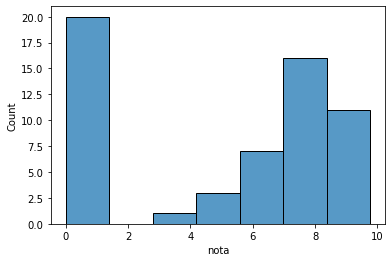

In [17]:
sns.histplot(data=grades,x='nota')

In [21]:
grades.to_csv('data/nonpublic/grades-4300459-2020.csv',index=False)

## Anonymize mv files

In [46]:
files = ['mv-2020-FD.csv','mv-2020-IF.csv','mv-2020-FEA.csv','mv-2020-FFLCH.csv','mv-2020-FMRP.csv','mv-2020-FE.csv']
for file in files:
    dir1 = 'data/nonpublic/'
    dir2 = 'data/processed/'
    mv = pd.read_csv(dir1+file)
    del mv['courseid']
    s = mv['course']
    idmap = dict(list(zip(s.unique(),range(len(s.unique())))))
    mv['course'] = s.map(idmap)
    mv.to_csv(dir2+file,index=False)